In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, auc, balanced_accuracy_score, confusion_matrix, f1_score, precision_score, average_precision_score, roc_auc_score,  recall_score,  precision_recall_curve #some scoring functions

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest, RandomForestClassifier # Some classifiers
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split #Cross validation tools, and a train/test split utility
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV #Hyper parameter search tools

from hyperopt import hp, tpe, STATUS_OK, fmin, Trials #Hyperparameter search using a loss function

In [3]:
df = pd.read_csv("creditcard.csv", delimiter=',', nrows=1000)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(int(nGraphRow), int(nGraphPerRow), i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [5]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna() # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

In [6]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

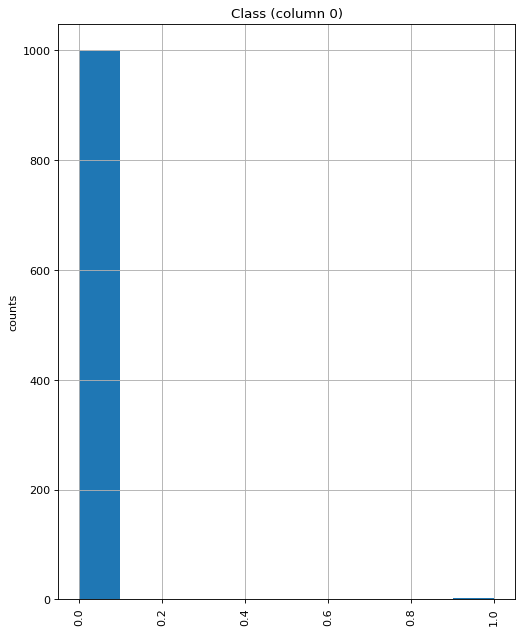

In [7]:
plotPerColumnDistribution(df, 10, 5)

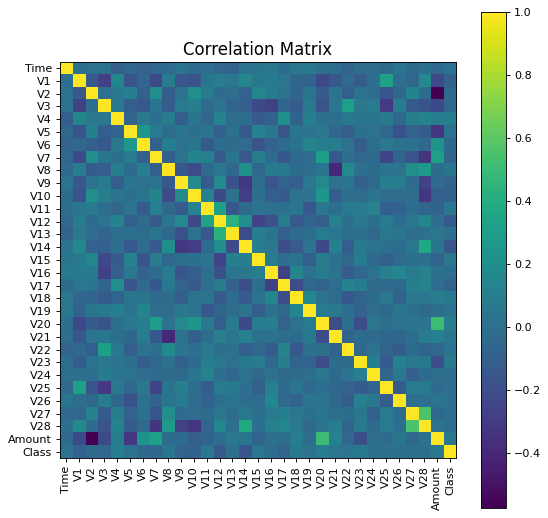

In [8]:
plotCorrelationMatrix(df, 8)

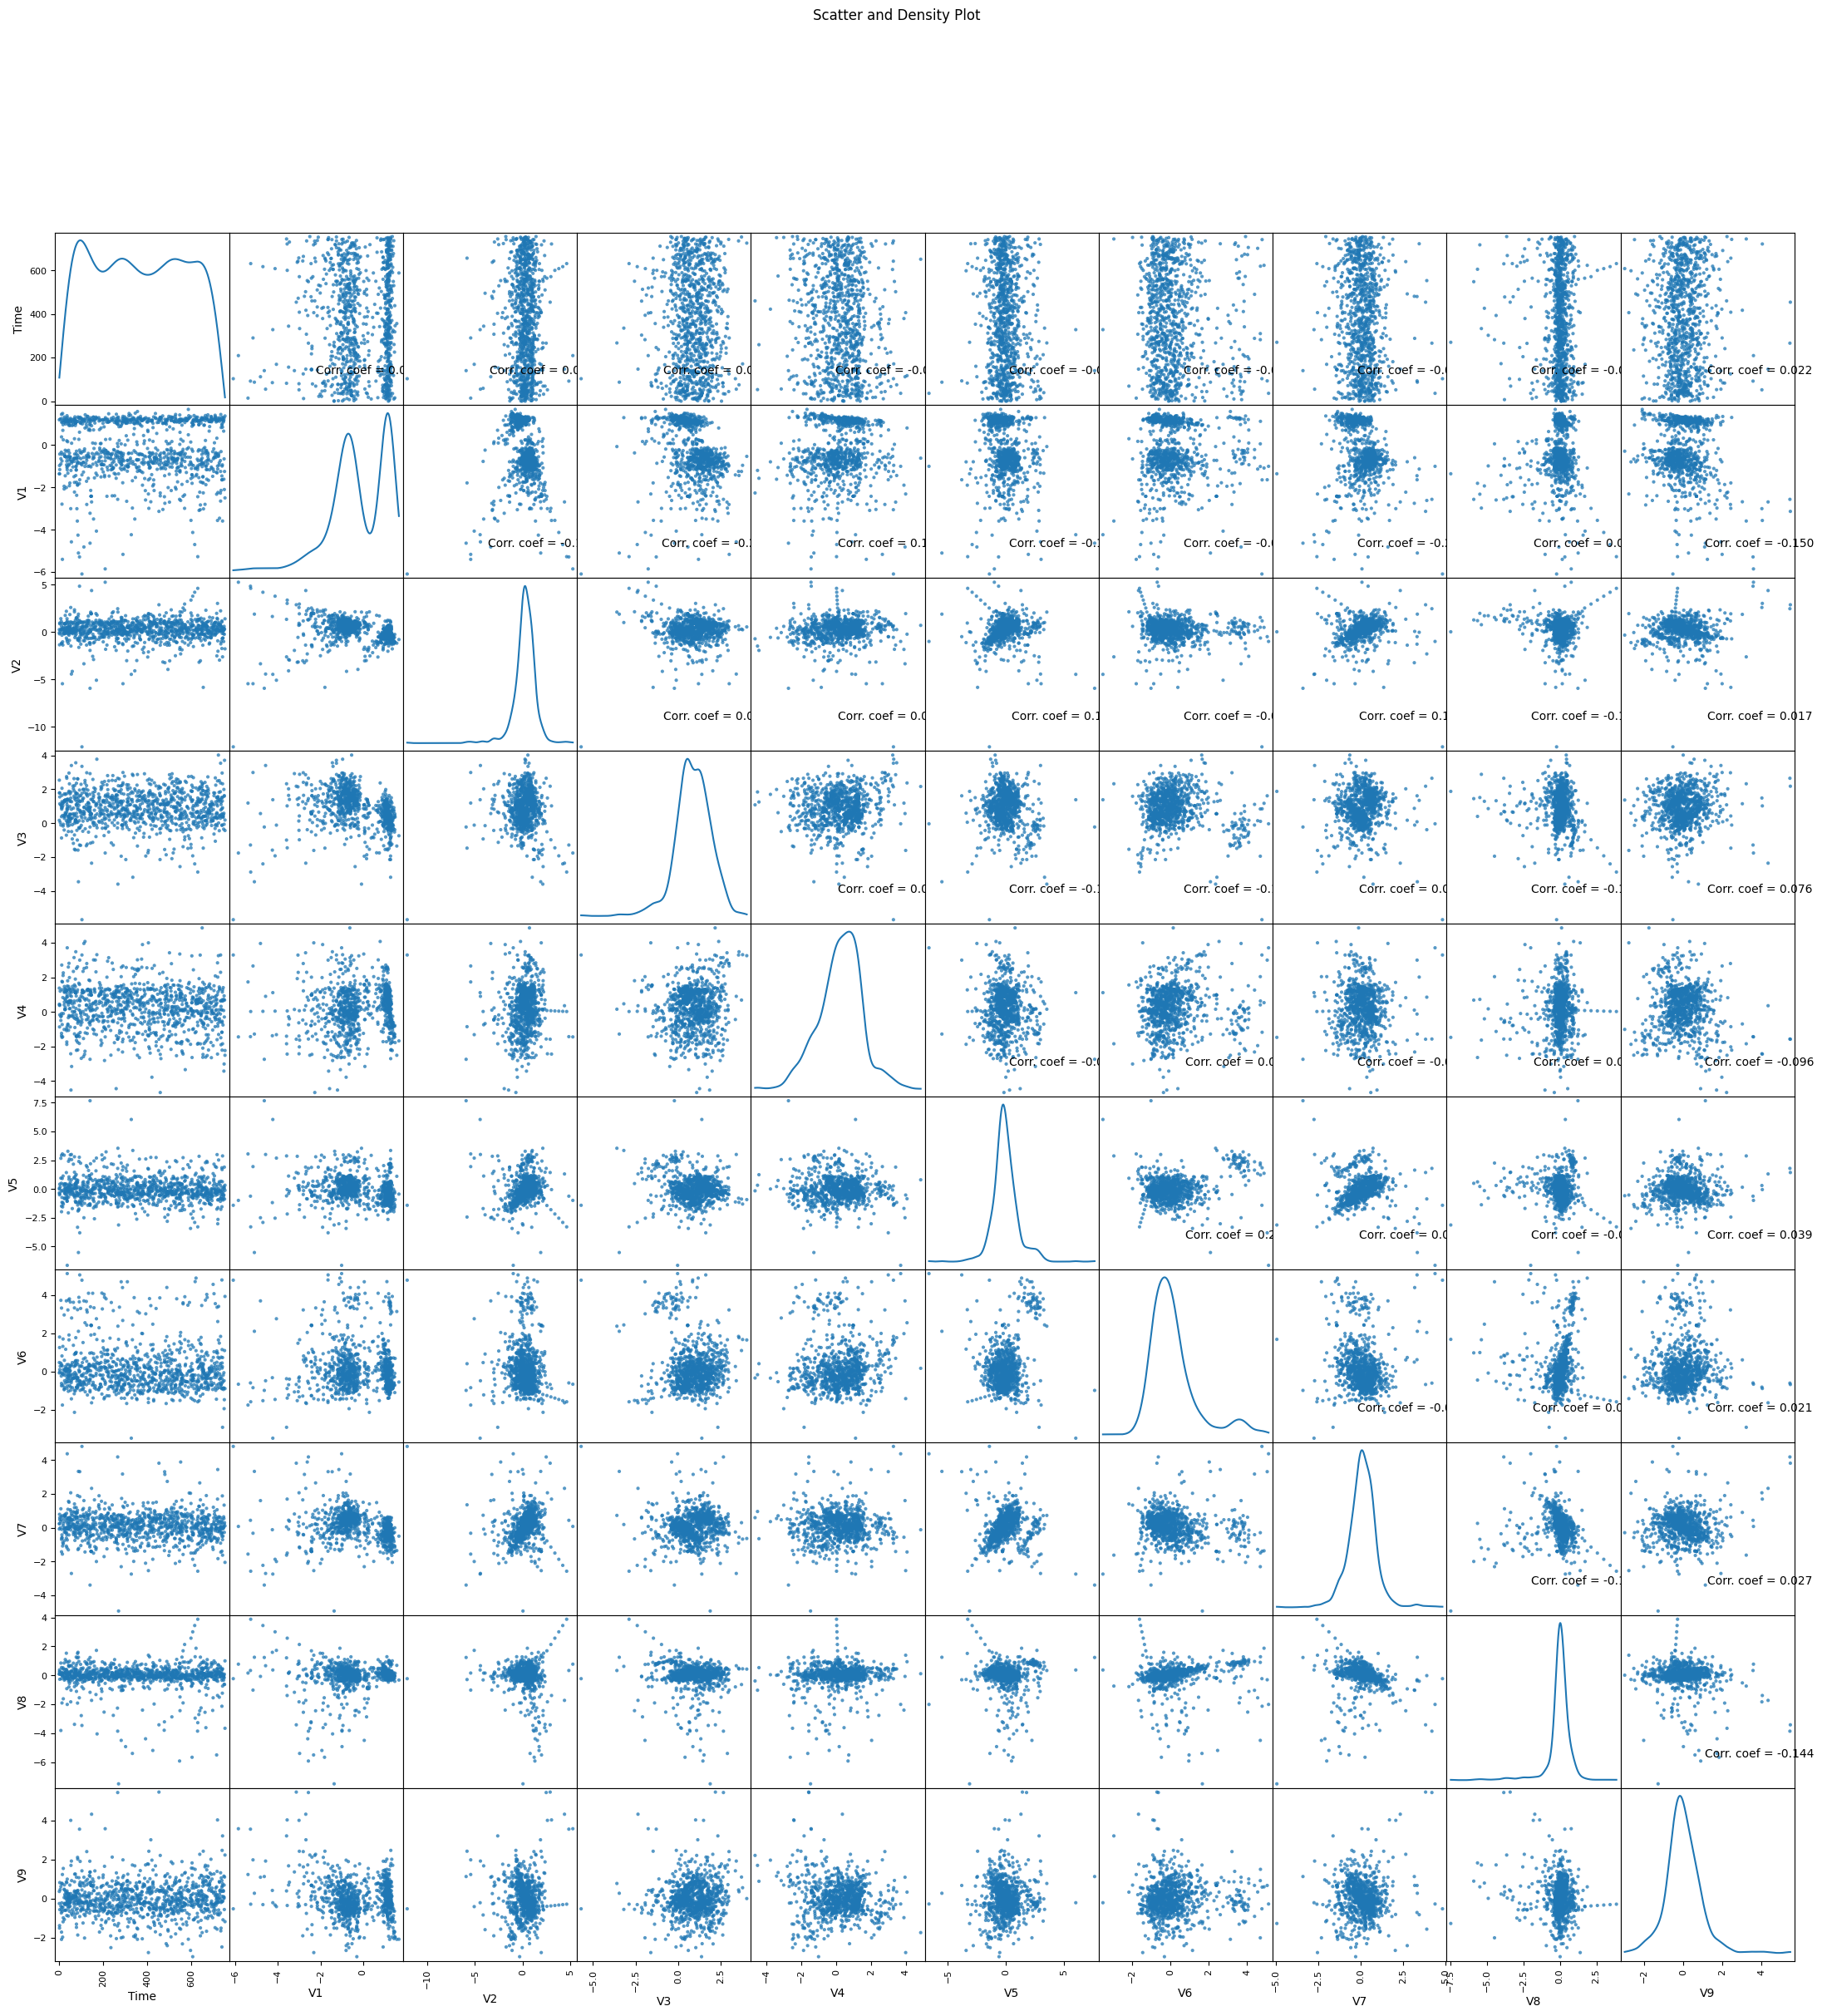

In [9]:
plotScatterMatrix(df, 27, 10) 

In [23]:
"""
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv', delimiter=',', nrows=1000)
# Separate features (X) and target (y)
X = df.iloc[:, 1:30]
y = df.iloc[:, 30:31]   

# Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#include random_state=(int) to get the same split every time you run the code
#the stratify=y parameter of train_test_split gives an even ratio of our imbalanced class in each of our splits.

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
"""
df = pd.read_csv('creditcard.csv', delimiter=',')
df.dataframeName = 'creditcard.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')


There are 284807 rows and 31 columns


The data features are already PCA-transformed, so we do not need to normalize the data further


In [24]:
X = df.iloc[:, 1:30]
y = df.iloc[:, 30:31]
X.head(), y.head()

(         V1        V2        V3        V4        V5        V6        V7  \
 0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9       V10  ...       V20       V21       V22       V23  \
 0  0.098698  0.363787  0.090794  ...  0.251412 -0.018307  0.277838 -0.110474   
 1  0.085102 -0.255425 -0.166974  ... -0.069083 -0.225775 -0.638672  0.101288   
 2  0.247676 -1.514654  0.207643  ...  0.524980  0.247998  0.771679  0.909412   
 3  0.377436 -1.387024 -0.054952  ... -0.208038 -0.108300  0.005274 -0.190321   
 4 -0.270533  0.817739  0.753074  ...  0.408542 -0.009431  0.798278 -0.137458   
 
         V24       V25       V26       V27       V28  

In [25]:
# Let's split our dataset and see what it looks like:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.25)
training_fraud = sum(y_train.values)
training_fraud_pct = sum(y_train.values)/len(y_train.values)*100
test_fraud = sum(y_test.values)
test_fraud_pct = sum(y_test.values)/len(y_test.values)*100
print("X train: {}\nX test:  {}\ny_train: {}\ny test:  {} \nFraud in train set: {},   {:2f}%\nFraud in test set:  {},  {:2f}%\n".format( X_train.shape, 
                                                                                                                      X_test.shape, 
                                                                                                                      y_train.shape, 
                                                                                                                      y_test.shape, 
                                                                                                                      training_fraud[0], training_fraud_pct[0],
                                                                                                                      test_fraud[0], test_fraud_pct[0]))

X train: (213605, 29)
X test:  (71202, 29)
y_train: (213605, 1)
y test:  (71202, 1) 
Fraud in train set: 369,   0.172749%
Fraud in test set:  123,  0.172748%



In [28]:
model = RandomForestClassifier()
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

In [29]:
y_pred = model.predict(X_test)

In [30]:
def print_scores(y_t, y_p):
    print(f'Accuracy  :{accuracy_score(y_t, y_p):.2f}' )
    print(f'Balanced  :{balanced_accuracy_score(y_t, y_p):.2f}' )
    print(f'F1        :{f1_score(y_t, y_p):.2f}' )
    print(f'Precision :{precision_score(y_t, y_p):.2f}' )
    print(f'Recall    :{recall_score(y_t, y_p):.2f}' )
    print(f'roc auc   :{roc_auc_score(y_t, y_p):.2f}' )
    print(f'pr)auc    :{average_precision_score(y_t, y_p):.2f}' )
print_scores(y_test, y_pred)

Accuracy  :1.00
Balanced  :0.90
F1        :0.88
Precision :0.98
Recall    :0.80
roc auc   :0.90
pr)auc    :0.79
